In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [3]:
from masa_utils import PsuedoLog
from masa_utils import Debye_sum_res_f
from masa_utils import InducedPolarizationSimulation as IP_np
from masa_utils import Optimization as opt_np
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Pelton_res_f, Debye_sum_t,ColeCole_f
from masa_utils_pytorch import Optimization

# multiple reference models Pelton model

In [4]:
# low time constant 
tau_true=0.1
parm_true = torch.tensor([np.log(0.2), 0.50, np.log(tau_true), 0.5], dtype=torch.float) #, requires_grad=False)
# inital reference model
np_mvec_true = parm_true.detach().numpy()

parm_ref1 = torch.tensor([np.log(0.22), 0.1, np.log(0.05), 0.6], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref2 = torch.tensor([np.log(0.22), 0.1, np.log(0.2), 0.6], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref3 = torch.tensor([np.log(0.22), 0.1, np.log(0.05), 0.4], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref4 = torch.tensor([np.log(0.22), 0.1, np.log(0.2), 0.4], dtype=torch.float, requires_grad=True) #, requires_grad=False)

nref= 4
parm_ref = [parm_ref1, parm_ref2, parm_ref3, parm_ref4]

# Define TDIP using Frecuency model

In [5]:
basefreq = 0.125
duty = 0.5
tstrt = 0
tend = 8.0
ntime = 2**14
print(ntime)
tstep = (tend - tstrt) / ntime
print(tstep)
ftesp = 1 / tend
times = np.arange(tstrt, tend, tstep)
freq = np.fft.fftfreq(ntime, tstep)
# freq =  np.arange(ntime) * ftesp / ntime
print(freq)
print(times)
print(times.shape)
print(freq.shape)

16384
0.00048828125
[ 0.     0.125  0.25  ... -0.375 -0.25  -0.125]
[0.00000000e+00 4.88281250e-04 9.76562500e-04 ... 7.99853516e+00
 7.99902344e+00 7.99951172e+00]
(16384,)
(16384,)


In [6]:
IP_model = Pelton_res_f(freq=freq)
sim = InducedPolarizationSimulation(
    ip_model=IP_model,
    mode="tdip_f",
    times=times,
    log2max=6,
    log2min=-6
    )
# print(sim.times.shape)
print(sim.ip_model.freq.shape)
print(sim.ip_model.freq)

torch.Size([16384])
tensor([ 0.0000+0.j,  0.1250+0.j,  0.2500+0.j,  ..., -0.3750+0.j, -0.2500+0.j,
        -0.1250+0.j])


Source wave form: 0.125 base frequency\
Time range 0-8sec, full waveform\
50Hz sammling data\
Windoes 25Hz, every 0.04sec\


In [7]:
windows_lin_step = 0.02
nlin_strt = 2
nlin = 4
windows_lin = np.arange(nlin)*windows_lin_step + nlin_strt* windows_lin_step
windows_log_strt = (nlin+nlin_strt)*windows_lin_step
# logstep = np.log10(windows_cen01.max()/windows_cen01.min())
logstep = np.log10(windows_lin[-1]/windows_lin[-2])
print(logstep)
windows_log_end = duty/basefreq
windows_log = 10**np.arange(
    np.log10(windows_log_strt),
    np.log10(windows_log_end), logstep)
windows_cen=np.r_[windows_lin, windows_log]
nhalf = len(windows_cen)
print(windows_cen)
windows_cen = np.r_[windows_cen, duty/basefreq + windows_cen]
print(windows_cen)
sim.get_windows(windows_cen)
sim.windows_end[nhalf-1]  = duty/basefreq
sim.windows_strt[nhalf] = sim.windows_strt[0] + duty/basefreq
sim.windows_end[-1] = 1/basefreq 
sim.get_window_matrix(times=times)
print(sim.times.shape)
print(sim.ip_model.freq.shape)
print(sim.ip_model.freq)

0.09691001300805642
[0.04       0.06       0.08       0.1        0.12       0.15
 0.1875     0.234375   0.29296875 0.36621094 0.45776367 0.57220459
 0.71525574 0.89406967 1.11758709 1.39698386 1.74622983 2.18278728
 2.72848411 3.41060513]
[0.04       0.06       0.08       0.1        0.12       0.15
 0.1875     0.234375   0.29296875 0.36621094 0.45776367 0.57220459
 0.71525574 0.89406967 1.11758709 1.39698386 1.74622983 2.18278728
 2.72848411 3.41060513 4.04       4.06       4.08       4.1
 4.12       4.15       4.1875     4.234375   4.29296875 4.36621094
 4.45776367 4.57220459 4.71525574 4.89406967 5.11758709 5.39698386
 5.74622983 6.18278728 6.72848411 7.41060513]
torch.Size([16384])
torch.Size([16384])
tensor([ 0.0000+0.j,  0.1250+0.j,  0.2500+0.j,  ..., -0.3750+0.j, -0.2500+0.j,
        -0.1250+0.j])


In [8]:
print(sim.windows_strt[nhalf-1], sim.windows_end[nhalf-1])
print(sim.windows_strt[-1], sim.windows_end[-1])

tensor(3.0695) tensor(4.)
tensor(7.0695) tensor(8.)


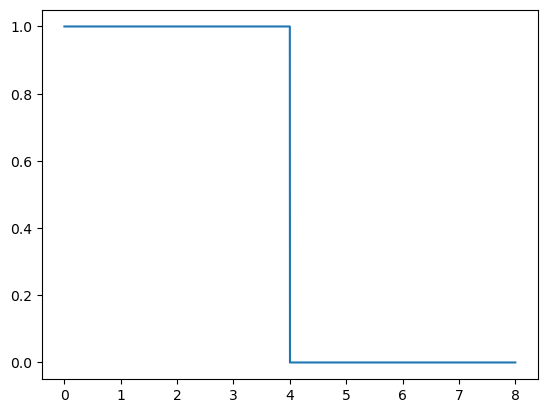

In [9]:
basefreq = 0.125
duty = 0.5
sim.set_current_wave(basefreq=basefreq, duty=duty)
plt.plot(sim.times, sim.curr)

In [10]:
print(sim.times.shape)
print(np.log2(sim.times.shape[0]))
sim.count_data_windows(sim.times)
print(sim.times.shape)
print(sim.ip_model.freq.shape)
print(sim.ip_model.freq)

torch.Size([16384])
14.0
torch.Size([16384])
torch.Size([16384])
tensor([ 0.0000+0.j,  0.1250+0.j,  0.2500+0.j,  ..., -0.3750+0.j, -0.2500+0.j,
        -0.1250+0.j])


In [11]:
count = sim.count_data_windows(sim.times)
print(count[:nhalf])
print(count[nhalf:])
print(count[nhalf-1], count[-1])

tensor([  41.,   41.,   41.,   41.,   51.,   69.,   87.,  109.,  136.,  169.,
         211.,  264.,  329.,  412.,  515.,  644.,  805., 1006., 1257., 1906.])
tensor([  41.,   41.,   41.,   41.,   51.,   69.,   87.,  109.,  136.,  169.,
         211.,  264.,  329.,  412.,  515.,  644.,  805., 1006., 1257., 1905.])
tensor(1906.) tensor(1905.)


In [12]:

dobs_clean=sim.dpred(parm_true).detach()
abs_max = max(abs(dobs_clean)).detach().numpy()
relative_error = torch.tensor(0.01)
noise_floor = torch.tensor(abs_max * 1e-3)
torch.random.seed()
dobs =  dobs_clean + torch.rand(len(dobs_clean)) * torch.sqrt(
        (relative_error * abs(dobs_clean))**2 
        + (noise_floor*torch.ones(len(dobs_clean)))**2
    )


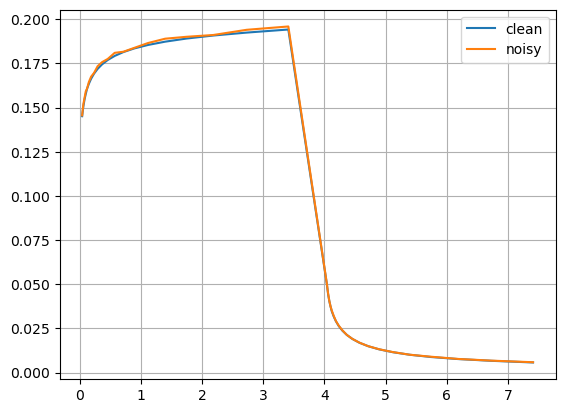

In [13]:
plt.plot(windows_cen, dobs_clean.numpy(), label='clean')
plt.plot(windows_cen, dobs.numpy(), label='noisy')
# plt.plot(windows_cen, dinit.numpy(), label='init')
plt.legend()
plt.grid()

In [14]:

print(sim.times.shape)
print(sim.ip_model.freq.shape)
print(sim.ip_model.freq)
print(sim.ip_model.freq[0])
print(sim.ip_model.freq[-1])
# freq = sim.ip_model.freq

torch.Size([16384])
torch.Size([16384])
tensor([ 0.0000+0.j,  0.1250+0.j,  0.2500+0.j,  ..., -0.3750+0.j, -0.2500+0.j,
        -0.1250+0.j])
tensor(0.+0.j)
tensor(-0.1250+0.j)


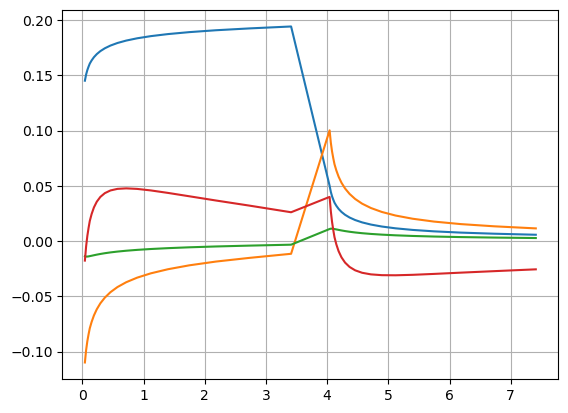

In [15]:

J =sim.J(parm_true)
plt.plot(windows_cen, J.numpy(), label='J')

plt.grid()

# Optimization

In [16]:
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
# opt.Wd = torch.diag(torch.ones(len(dobs)))
opt.Ws = torch.eye(len(parm_ref1))

In [17]:
print(opt.Wd)

tensor([[ 680.9265,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000,  652.9346,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000,    0.0000,  637.5814,  ...,    0.0000,    0.0000,
            0.0000],
        ...,
        [   0.0000,    0.0000,    0.0000,  ..., 4782.4370,    0.0000,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000, 4861.4297,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
         4928.3296]])


In [18]:
beta0_ratio = 1
niter = 80
stol=1e-6
coolingFactor = 2.0
coolingRate = 2
mu= 1e-3

In [19]:
models_rec = []
dpreds = []
errors_prg = []
models_prg = []
dinit_refs = []
for i in range(nref):
    parm_init = parm_ref[i]
    beta0 = opt.BetaEstimate_byEig(
        m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt.GradientDescent(stol=stol,l1reg=True,
    coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
        mvec_init=parm_init,niter=niter,beta0=beta0,
        update_Wsen=True,ELS=True, BLS=True)
    dinit_refs.append(opt.dpred(parm_init))
    models_rec.append(mpred)
    dpreds.append(opt.dpred(mpred))
    errors_prg.append(opt.error_prg)
    models_prg.append(opt.mvec_prg)


tensor(1.6576e+08)
  1, beta:1.7e+08, step:9.5e-07, gradient:1.5e+05,  f:4.3e+04
  2, beta:1.7e+08, step:9.5e-07, gradient:2.2e+08,  f:1.9e+05
  3, beta:8.3e+07, step:1.9e-06, gradient:1.1e+08,  f:4.3e+04
  4, beta:8.3e+07, step:9.5e-07, gradient:1.1e+08,  f:8.2e+04
  5, beta:4.1e+07, step:1.9e-06, gradient:5.5e+07,  f:4.3e+04
  6, beta:4.1e+07, step:9.5e-07, gradient:5.5e+07,  f:5.2e+04
  7, beta:2.1e+07, step:1.9e-06, gradient:2.8e+07,  f:4.3e+04
  8, beta:2.1e+07, step:9.5e-07, gradient:2.8e+07,  f:4.5e+04
  9, beta:1.0e+07, step:1.9e-06, gradient:1.4e+07,  f:4.3e+04
 10, beta:1.0e+07, step:9.5e-07, gradient:1.4e+07,  f:4.4e+04
 11, beta:5.2e+06, step:1.9e-06, gradient:7.0e+06,  f:4.3e+04
 12, beta:5.2e+06, step:9.5e-07, gradient:6.8e+06,  f:4.3e+04
 13, beta:2.6e+06, step:1.9e-06, gradient:3.6e+06,  f:4.3e+04
 14, beta:2.6e+06, step:9.5e-07, gradient:3.3e+06,  f:4.3e+04
 15, beta:1.3e+06, step:9.5e-07, gradient:1.7e+06,  f:4.3e+04
 16, beta:1.3e+06, step:9.5e-07, gradient:1.8e+06, 

In [20]:
print( "Parameter:     res0,   chg,       tau,     c")

for i in range(nref):
    np_mvec_ref = parm_ref[i].detach().numpy()
    np_mvec_est = models_rec[i].detach().numpy()
    print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1]:.3f} & {np.exp(np_mvec_ref[2]):.2e} & {np_mvec_ref[3]:.3f}")
    print(f"est{i+1}     & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1]:.3f} & { np.exp(np_mvec_est[2]):.2e} & { np_mvec_est[3]:.3f}")
print(f"true     & {np.exp(np_mvec_true[0]):.2e} & {np_mvec_true[1]:.3f} & {np.exp(np_mvec_true[2]):.2e} & {np_mvec_true[3]:.3f}")

Parameter:     res0,   chg,       tau,     c
ref1     & 2.20e-01 & 0.100 & 5.00e-02 & 0.600
est1     & 2.01e-01 & 0.606 & 5.33e-02 & 0.469
ref2     & 2.20e-01 & 0.100 & 2.00e-01 & 0.600
est2     & 2.01e-01 & 0.401 & 2.00e-01 & 0.548
ref3     & 2.20e-01 & 0.100 & 5.00e-02 & 0.400
est3     & 2.01e-01 & 0.610 & 5.19e-02 & 0.468
ref4     & 2.20e-01 & 0.100 & 2.00e-01 & 0.400
est4     & 2.01e-01 & 0.406 & 1.93e-01 & 0.545
true     & 2.00e-01 & 0.500 & 1.00e-01 & 0.500


In [23]:
nwindow = len(windows_cen)
ind_on = windows_cen <= duty*(1/basefreq)
ind_off = windows_cen > duty*(1/basefreq)
windows_on = windows_cen[ind_on]
windows_off = windows_cen[ind_off]
windows_off_0 = windows_off-duty*(1/basefreq)


In [24]:
dest_on_np =[]
dest_off_np =[]
dinit_on_np =[]
dinit_off_np =[]
dest_J_on_np =[]
dest_J_off_np =[]
for i in range(nref):
    dest = dpreds[i].detach().numpy()
    dest_J = sim.J(parm_ref[i]).detach().numpy()
    dest_J_on_np.append(dest_J[ind_on])
    dest_J_off_np.append(dest_J[ind_off])
    dest_on_np.append(dest[ind_on]) 
    dest_off_np.append(dest[ind_off])
    dinit = dinit_refs[i].detach().numpy()
    dinit_on_np.append(dinit[ind_on])
    dinit_off_np.append(dinit[ind_off])
dobs_on = dobs[ind_on].detach().numpy().flatten()
dobs_off = dobs[ind_off].detach().numpy().flatten()


In [25]:
PL_tdip = PsuedoLog(
            logmin=1e-3,
            linScale=0.2,
            logminx=0.1,
            linScalex=0.5)

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


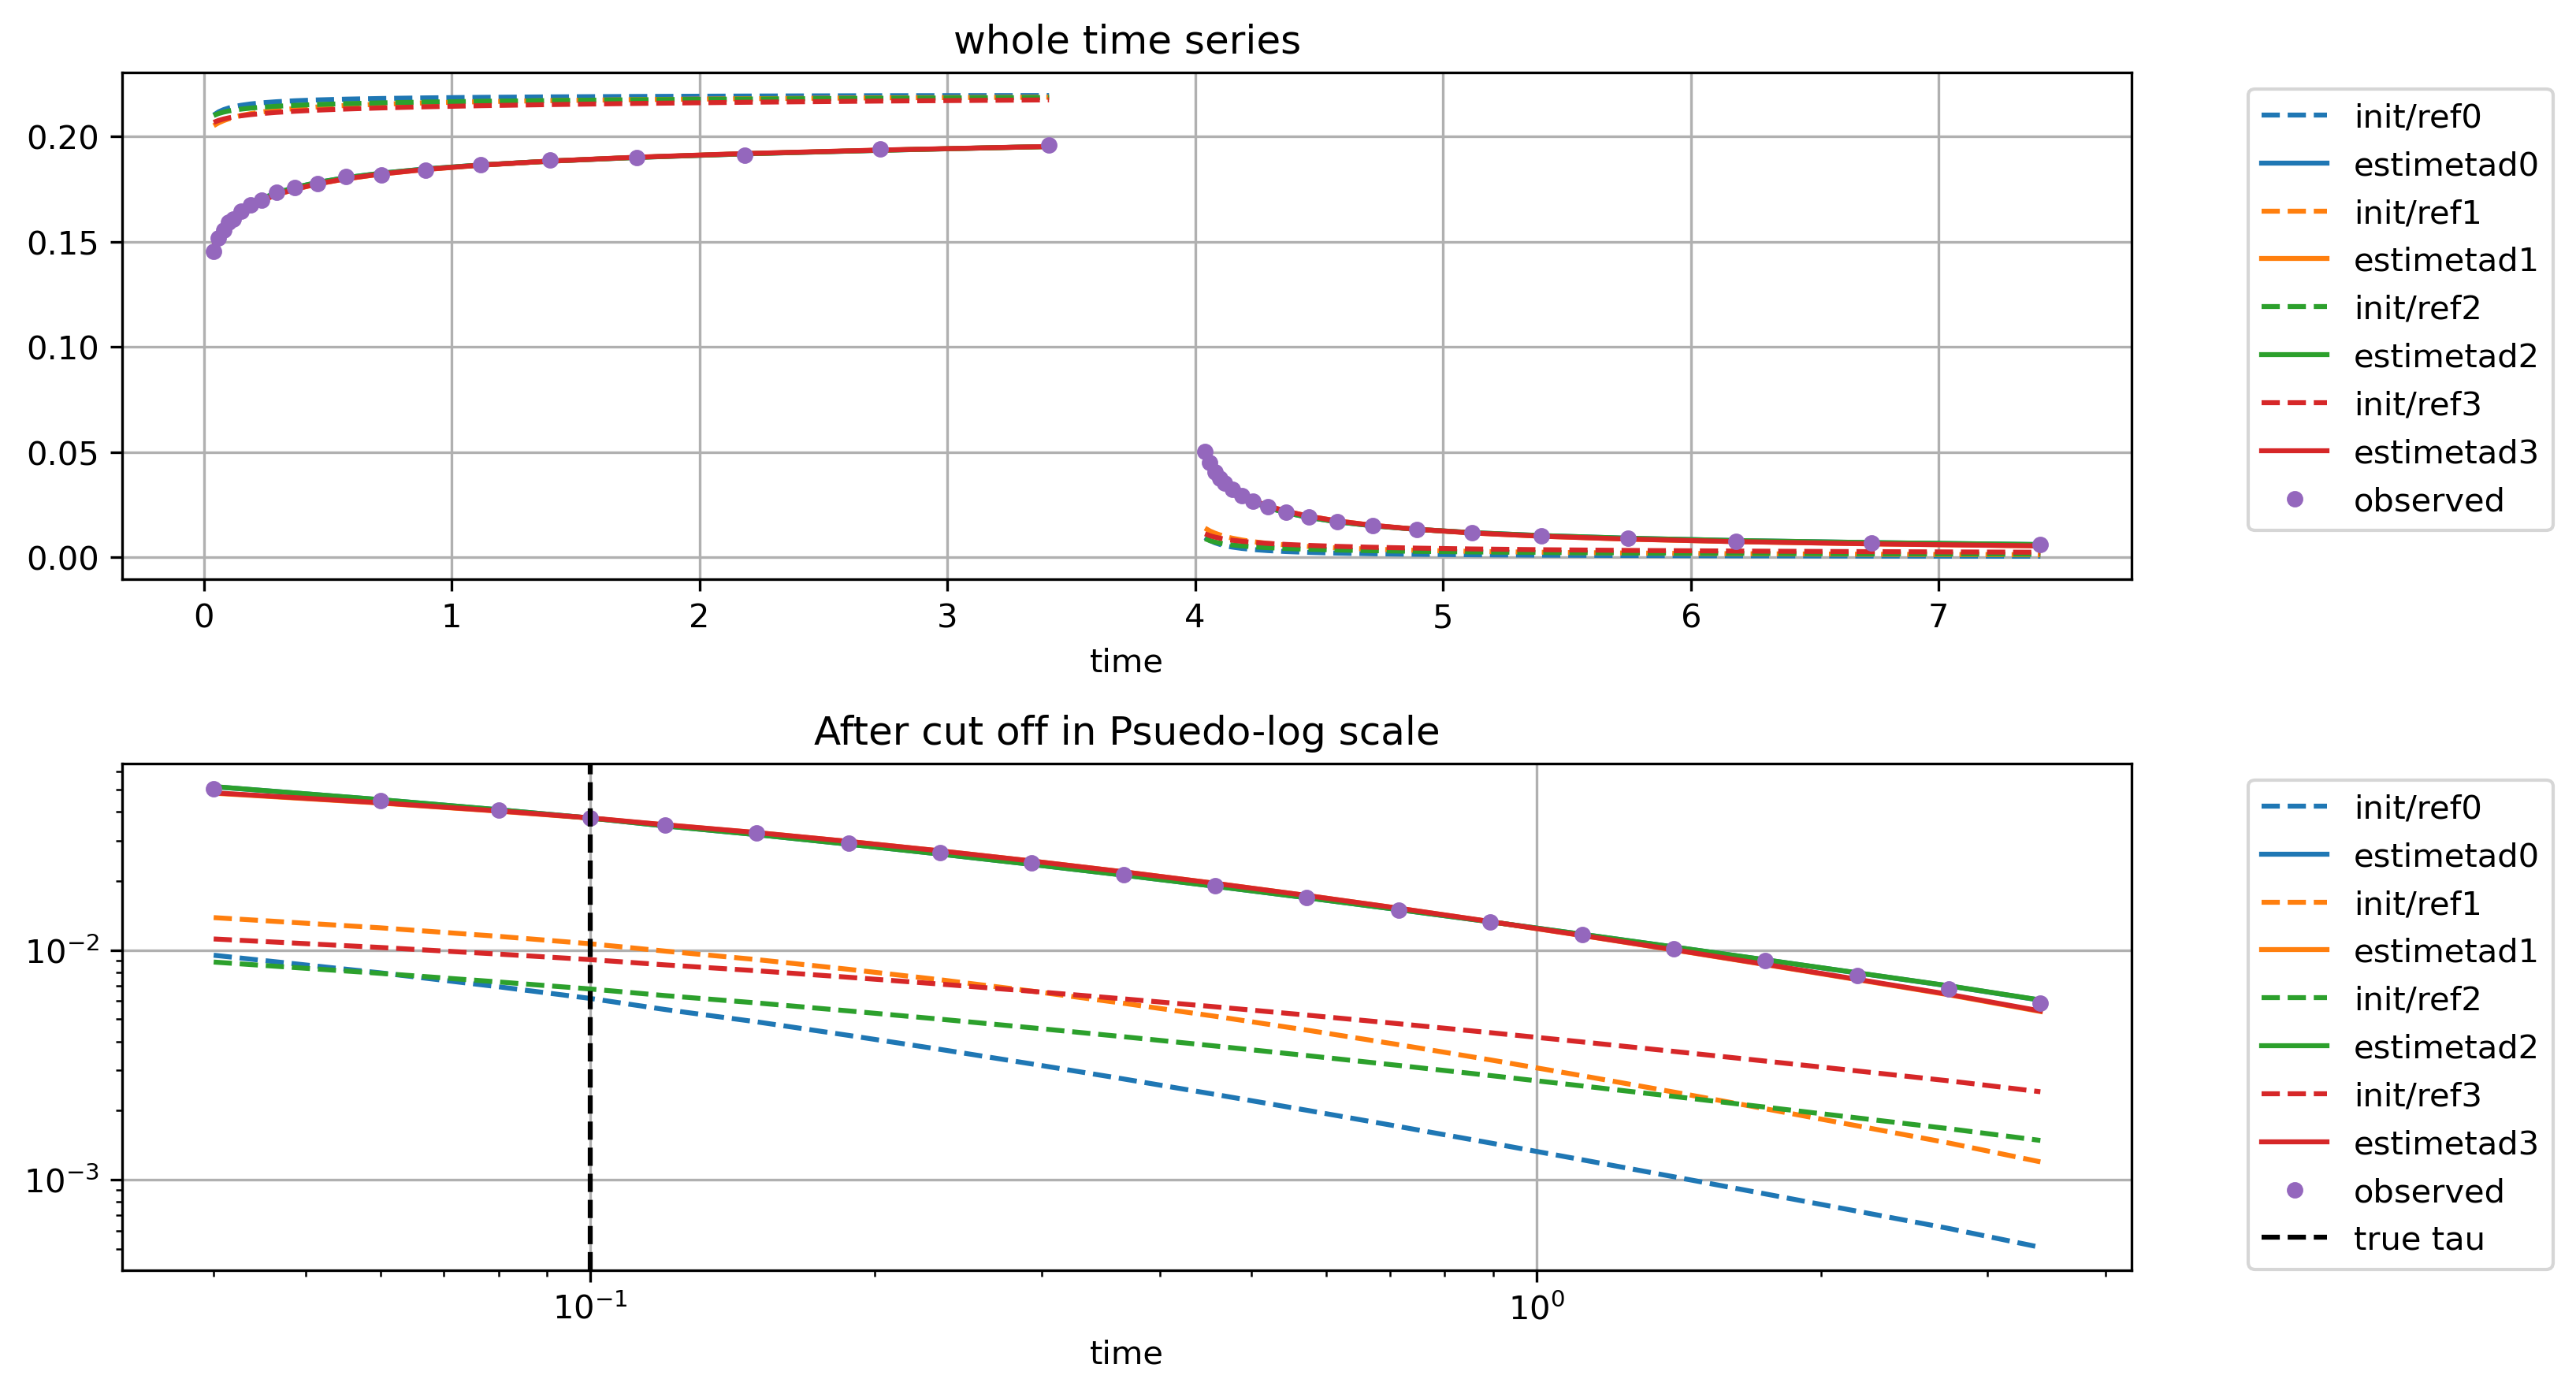

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(11, 6),dpi=300)

for i in range(nref):
    ax[0].plot(windows_on,dinit_on_np[i], f'C{i}', linestyle="--",label=f'init/ref{i}')
    ax[0].plot(windows_off,dinit_off_np[i], f'C{i}', linestyle="--")
    ax[0].plot(windows_on,dest_on_np[i], f'C{i}', label=f'estimetad{i}')
    ax[0].plot(windows_off,dest_off_np[i], f'C{i}')

ax[0].plot(windows_on,dobs_on, f'C{nref}', label='observed',
           linestyle="",markersize=4.0, marker="o",)
ax[0].plot(windows_off,dobs_off, f'C{nref}',
           linestyle="",markersize=4.0, marker="o")

for i in range(nref):
      ax[1].loglog(windows_off_0, dinit_off_np[i], color=f'C{i}', linestyle="--",label=f'init/ref{i}')
      ax[1].loglog(windows_off_0, dest_off_np[i], color=f'C{i}', label=f'estimetad{i}')
ax[1].loglog(windows_off_0, dobs_off, 
        color=f'C{nref}',linestyle="",markersize=4.0, marker="o", label='observed')
ax[1].axvline(x=tau_true, color='k', linestyle="--", label='true tau')

for a in ax:
        a.set_xlabel('time')
        a.grid()
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title("whole time series")
ax[1].set_title("After cut off in Psuedo-log scale")
plt.tight_layout()
plt.savefig("19_Pelton_res_tdip.jpg", dpi=300)

In [40]:
U_pelton = []
S_pelton=[]
S_pelton_norm = []
V_pelton=[]
for i in range(nref):
    J_np = opt.J(models_rec[i]).detach().numpy()
    U, S, V = np.linalg.svd(J_np, full_matrices=False)
    U_pelton.append(U)
    S_pelton.append(S)
    s_norm = S/S.max()
    S_pelton_norm.append(s_norm)
    V_pelton.append(V)


In [47]:
ind_ref =3
J_on = dest_J_on_np[ind_ref]
J_off = dest_J_off_np[ind_ref]
# dpred_true = sim.J(parm_true).detach().numpy()
# J_on = dpred_true[ind_on]
# J_off = dpred_true[ind_off]


In [48]:
PL_jac = PsuedoLog(
            logmin=1e-2,
            linScale=0.5,
            logminx=0.1,
            linScalex=1.0)

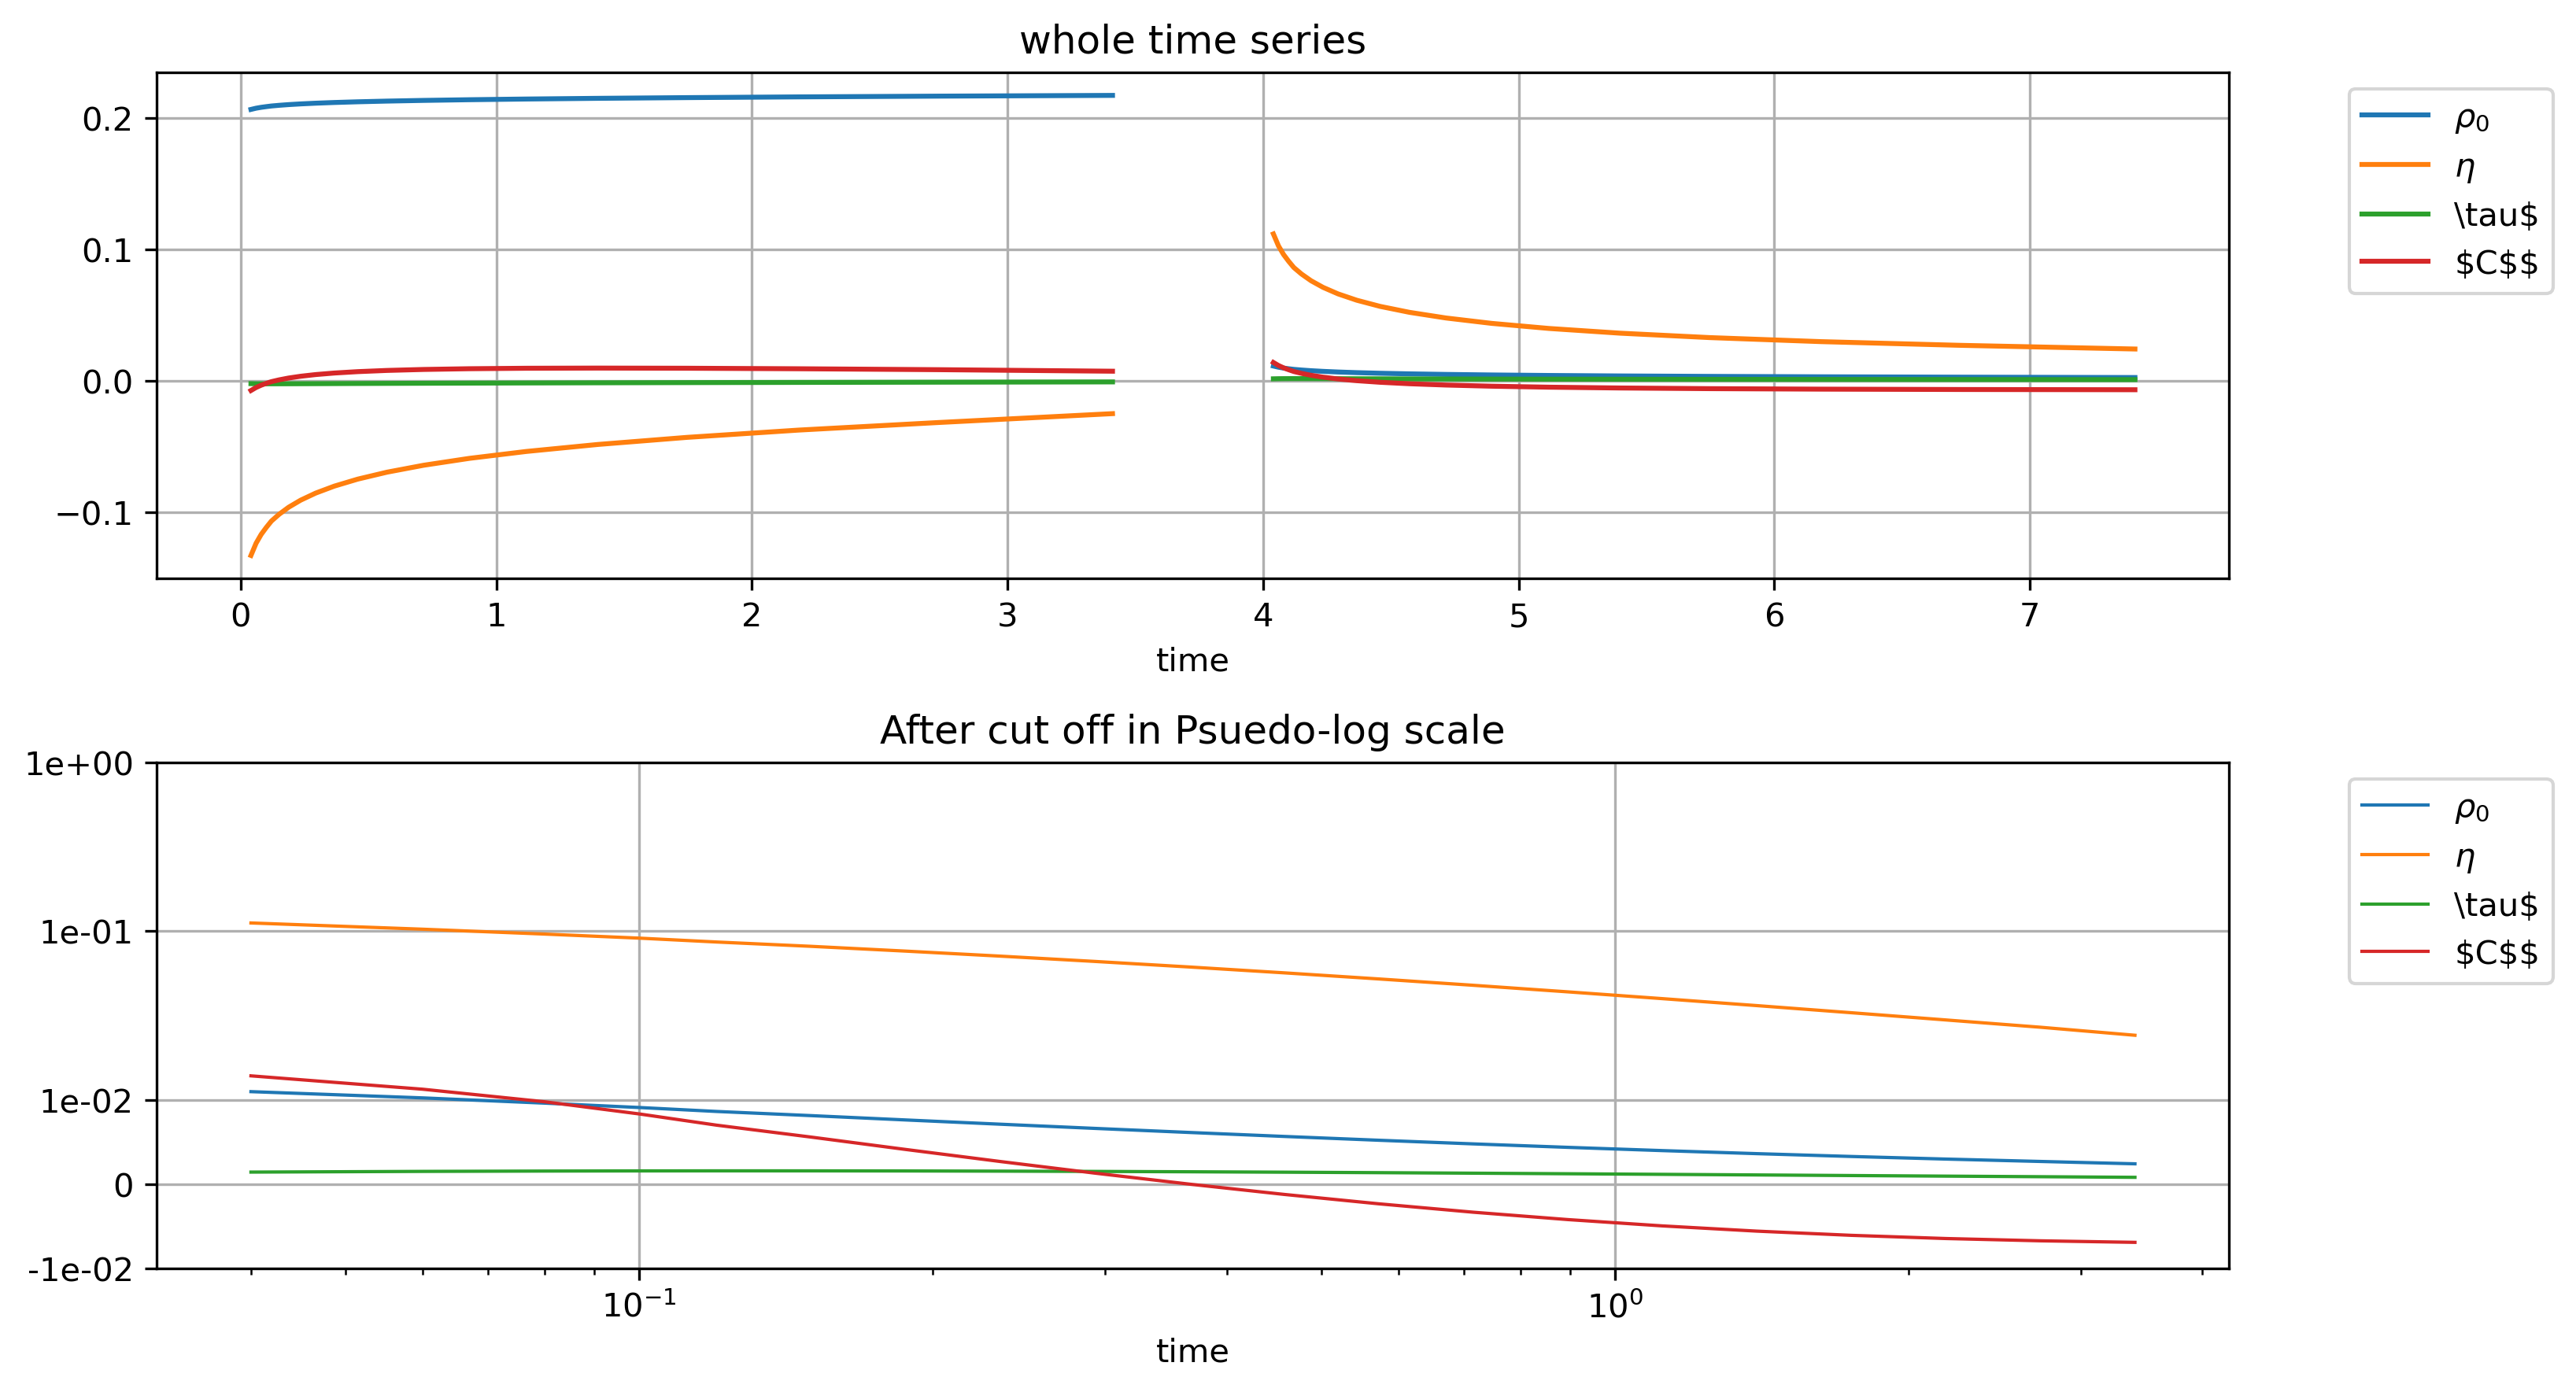

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(11, 6),dpi=300)

ax[0].plot(windows_on, J_on[:,0], 'C0', label=r"$\rho_0$")
ax[0].plot(windows_off,J_off[:,0], 'C0')
ax[0].plot(windows_on,J_on[:,1], 'C1', label=r"$\eta$")
ax[0].plot(windows_off,J_off[:,1], 'C1')
ax[0].plot(windows_on,J_on[:,2], 'C2', label=r"\tau$")
ax[0].plot(windows_off,J_off[:,2], 'C2')
ax[0].plot(windows_on,J_on[:,3], 'C3', label=r"$C$$")
ax[0].plot(windows_off,J_off[:,3], 'C3')

ax[1] = PL_jac.semiply(x=windows_off_0, y=J_off[:,0], ax=ax[1],
             color='C0', label=r"$\rho_0$")
ax[1] = PL_jac.semiply(x=windows_off_0, y=J_off[:,1], ax=ax[1],
             color='C1', label=r"$\eta$")
ax[1] = PL_jac.semiply(x=windows_off_0, y=J_off[:,2], ax=ax[1],
                   color='C2', label=r"\tau$")
ax[1] = PL_jac.semiply(x=windows_off_0, y=J_off[:,3], ax=ax[1],
                   color='C3',  label=r"$C$$")
PL_jac.pl_axes(ax=ax[1])

for a in ax:
        a.set_xlabel('time')
        a.grid()
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title("whole time series")
ax[1].set_title("After cut off in Psuedo-log scale")

plt.tight_layout()
plt.savefig("19_Pelton_res_tdp_J.jpg", dpi=300)

#  Lineary Weighted Debye model

In [136]:
ntau=5
taus = np.logspace(-1.5,0.5,ntau)
print(taus)
print(tstep)

[0.03162278 0.1        0.31622777 1.         3.16227766]
0.00048828125


In [137]:
IP_model = Debye_sum_t(times=times,tstep=tstep, ntau=ntau, taus=taus)
sim = InducedPolarizationSimulation(ip_model=IP_model, times=times, mode="tdip_t")

# IP_model = Pelton_debye_f(freq=freq, times=times, tstep=tstep, taus=taus,ntau=ntau)
# sim = InducedPolarizationSimulation(ip_model=IP_model, times=times, mode="tdip_f")


print(etas_view)

In [138]:
windows_lin_step = 0.02
nlin_strt = 2
nlin = 4
windows_lin = np.arange(nlin)*windows_lin_step + nlin_strt* windows_lin_step
windows_log_strt = (nlin+nlin_strt)*windows_lin_step
# logstep = np.log10(windows_cen01.max()/windows_cen01.min())
logstep = np.log10(windows_lin[-1]/windows_lin[-2])
print(logstep)
windows_log_end = duty/basefreq
windows_log = 10**np.arange(
    np.log10(windows_log_strt),
    np.log10(windows_log_end), logstep)
windows_cen=np.r_[windows_lin, windows_log]
nhalf = len(windows_cen)
print(windows_cen)
windows_cen = np.r_[windows_cen, duty/basefreq + windows_cen]
sim.get_windows(windows_cen)
sim.windows_end[nhalf-1]  = duty/basefreq
sim.windows_strt[nhalf] = sim.windows_strt[0] + duty/basefreq
sim.windows_end[-1] = 1/basefreq 
sim.get_window_matrix(times=times)
print(sim.times.shape)
print(sim.windows_end)
print(sim.windows_strt)

0.09691001300805642
[0.04       0.06       0.08       0.1        0.12       0.15
 0.1875     0.234375   0.29296875 0.36621094 0.45776367 0.57220459
 0.71525574 0.89406967 1.11758709 1.39698386 1.74622983 2.18278728
 2.72848411 3.41060513]
torch.Size([16384])
tensor([0.0500, 0.0700, 0.0900, 0.1100, 0.1350, 0.1688, 0.2109, 0.2637, 0.3296,
        0.4120, 0.5150, 0.6437, 0.8047, 1.0058, 1.2573, 1.5716, 1.9645, 2.4556,
        3.0695, 4.0000, 4.0500, 4.0700, 4.0900, 4.1100, 4.1350, 4.1687, 4.2109,
        4.2637, 4.3296, 4.4120, 4.5150, 4.6437, 4.8047, 5.0058, 5.2573, 5.5716,
        5.9645, 6.4556, 7.0695, 8.0000])
tensor([0.0300, 0.0500, 0.0700, 0.0900, 0.1100, 0.1350, 0.1688, 0.2109, 0.2637,
        0.3296, 0.4120, 0.5150, 0.6437, 0.8047, 1.0058, 1.2573, 1.5716, 1.9645,
        2.4556, 3.0695, 4.0300, 4.0500, 4.0700, 4.0900, 4.1100, 4.1350, 4.1687,
        4.2109, 4.2637, 4.3296, 4.4120, 4.5150, 4.6437, 4.8047, 5.0058, 5.2573,
        5.5716, 5.9645, 6.4556, 7.0695])


In [139]:
sim.set_current_wave(basefreq=basefreq, duty=duty)

count=sim.count_data_windows(sim.times)
print(count[:nhalf])
print(count[nhalf:])

tensor([  41.,   41.,   41.,   41.,   51.,   69.,   87.,  109.,  136.,  169.,
         211.,  264.,  329.,  412.,  515.,  644.,  805., 1006., 1257., 1906.])
tensor([  41.,   41.,   41.,   41.,   51.,   69.,   87.,  109.,  136.,  169.,
         211.,  264.,  329.,  412.,  515.,  644.,  805., 1006., 1257., 1905.])


In [140]:
parm_init = torch.tensor(
    # np.r_[np.log(0.2), 0.01*np.ones(ntau)],
    np.r_[np.log(0.22), 0.01*np.ones(ntau)],
    dtype=torch.float32,
    requires_grad=True
) #, requires_grad=False)
# parm_init = torch.tensor(np.r_[np.log(0.3), np.zeros(ntau), np.log(taus)], 
#                 dtype=torch.float32, requires_grad=True) #, requires_grad=False)
mvec_init = parm_init.detach().numpy()
dinit = sim.dpred(parm_init).detach()

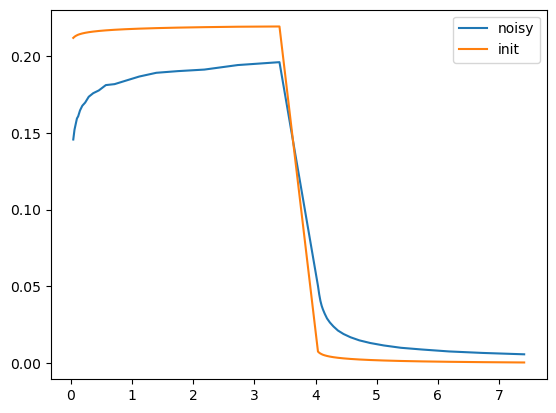

In [141]:
# plt.plot(windows_cen, dobs_clean.numpy(), label='clean')
plt.plot(windows_cen, dobs.numpy(), label='noisy')
plt.plot(windows_cen, dinit.numpy(), label='init')
plt.legend()


In [142]:
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
opt.Ws = torch.eye(len(parm_init))

In [143]:
niter = 80
stol=1e-6
coolingFactor = 2.0
coolingRate = 2
mu=1e-3
beta0_ratio = 1

In [144]:

beta0 = opt.BetaEstimate_byEig(
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
print(beta0)
# beta0=1e6

tensor(1.3272e+09)


In [145]:
mpred = opt.GradientDescent(stol=stol,
coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
    mvec_init=parm_init,niter=niter,beta0=beta0,l1reg=False,
    update_Wsen=True,ELS=True, BLS=True)

  1, beta:1.3e+09, step:7.8e-03, gradient:8.0e+05,  f:4.1e+04
  2, beta:1.3e+09, step:2.0e-03, gradient:2.7e+05,  f:4.1e+04
  3, beta:6.6e+08, step:1.6e-02, gradient:5.0e+05,  f:4.1e+04
  4, beta:6.6e+08, step:3.9e-03, gradient:1.8e+05,  f:4.1e+04
  5, beta:3.3e+08, step:3.1e-02, gradient:4.5e+05,  f:4.0e+04
  6, beta:3.3e+08, step:1.6e-02, gradient:1.7e+05,  f:4.0e+04
  7, beta:1.7e+08, step:6.2e-02, gradient:5.2e+05,  f:3.9e+04
  8, beta:1.7e+08, step:3.1e-02, gradient:1.9e+05,  f:3.9e+04
  9, beta:8.3e+07, step:1.2e-01, gradient:4.4e+05,  f:3.7e+04
 10, beta:8.3e+07, step:6.2e-02, gradient:1.8e+05,  f:3.7e+04
 11, beta:4.1e+07, step:2.5e-01, gradient:4.3e+05,  f:3.3e+04
 12, beta:4.1e+07, step:1.2e-01, gradient:2.1e+05,  f:3.3e+04
 13, beta:2.1e+07, step:5.0e-01, gradient:3.6e+05,  f:2.8e+04
 14, beta:2.1e+07, step:2.5e-01, gradient:2.5e+05,  f:2.7e+04
 15, beta:1.0e+07, step:5.0e-01, gradient:2.9e+05,  f:2.1e+04
 16, beta:1.0e+07, step:2.5e-01, gradient:7.0e+04,  f:2.0e+04
 17, bet

In [146]:
np_mvec_prg = opt.mvec_prg
np_mvec_init = parm_init.detach().numpy()
np_mvec_true = parm_true.detach().numpy()
np_mvec_est = mpred.detach().numpy()
dest = opt.dpred(mpred).detach()
mvec_pred = mpred.detach().numpy()
#taus = np.exp(mvec_pred[1+ntau:])

In [147]:
print(f"initial :{np.exp(np_mvec_init[0]):.2e}, {np_mvec_init[1].sum():.3f}")
print(f"est L2  :{np.exp(np_mvec_est[0]):.2e}, { np_mvec_est[1:].sum():.3f}")
print(f"true    :{np.exp(np_mvec_true[0]):.2e}, {np_mvec_true[1]:.3f}, {np.exp(np_mvec_true[2]):.2e}, {np_mvec_true[3]:.3f}")


initial :2.20e-01, 0.010
est L2  :2.03e-01, 0.356
true    :2.00e-01, 0.500, 1.00e-01, 0.500


In [148]:
nwindow = len(windows_cen)
ind_on = windows_cen <= duty*(1/basefreq)
ind_off = windows_cen > duty*(1/basefreq)
windows_on = windows_cen[ind_on]
windows_off = windows_cen[ind_off]
windows_off_0 = windows_off-duty*(1/basefreq)
dest_on = dest[ind_on].detach().numpy().flatten()
dest_off = dest[ind_off].detach().numpy().flatten()
dobs_on = dobs[ind_on].detach().numpy().flatten()
dobs_off = dobs[ind_off].detach().numpy().flatten()
dinit_on = dinit[ind_on].detach().numpy().flatten()
dinit_off = dinit[ind_off].detach().numpy().flatten()

In [149]:
PL_tdip = PsuedoLog(
            logmin=1e-3,
            linScale=0.2,
            logminx=0.1,
            linScalex=0.5)

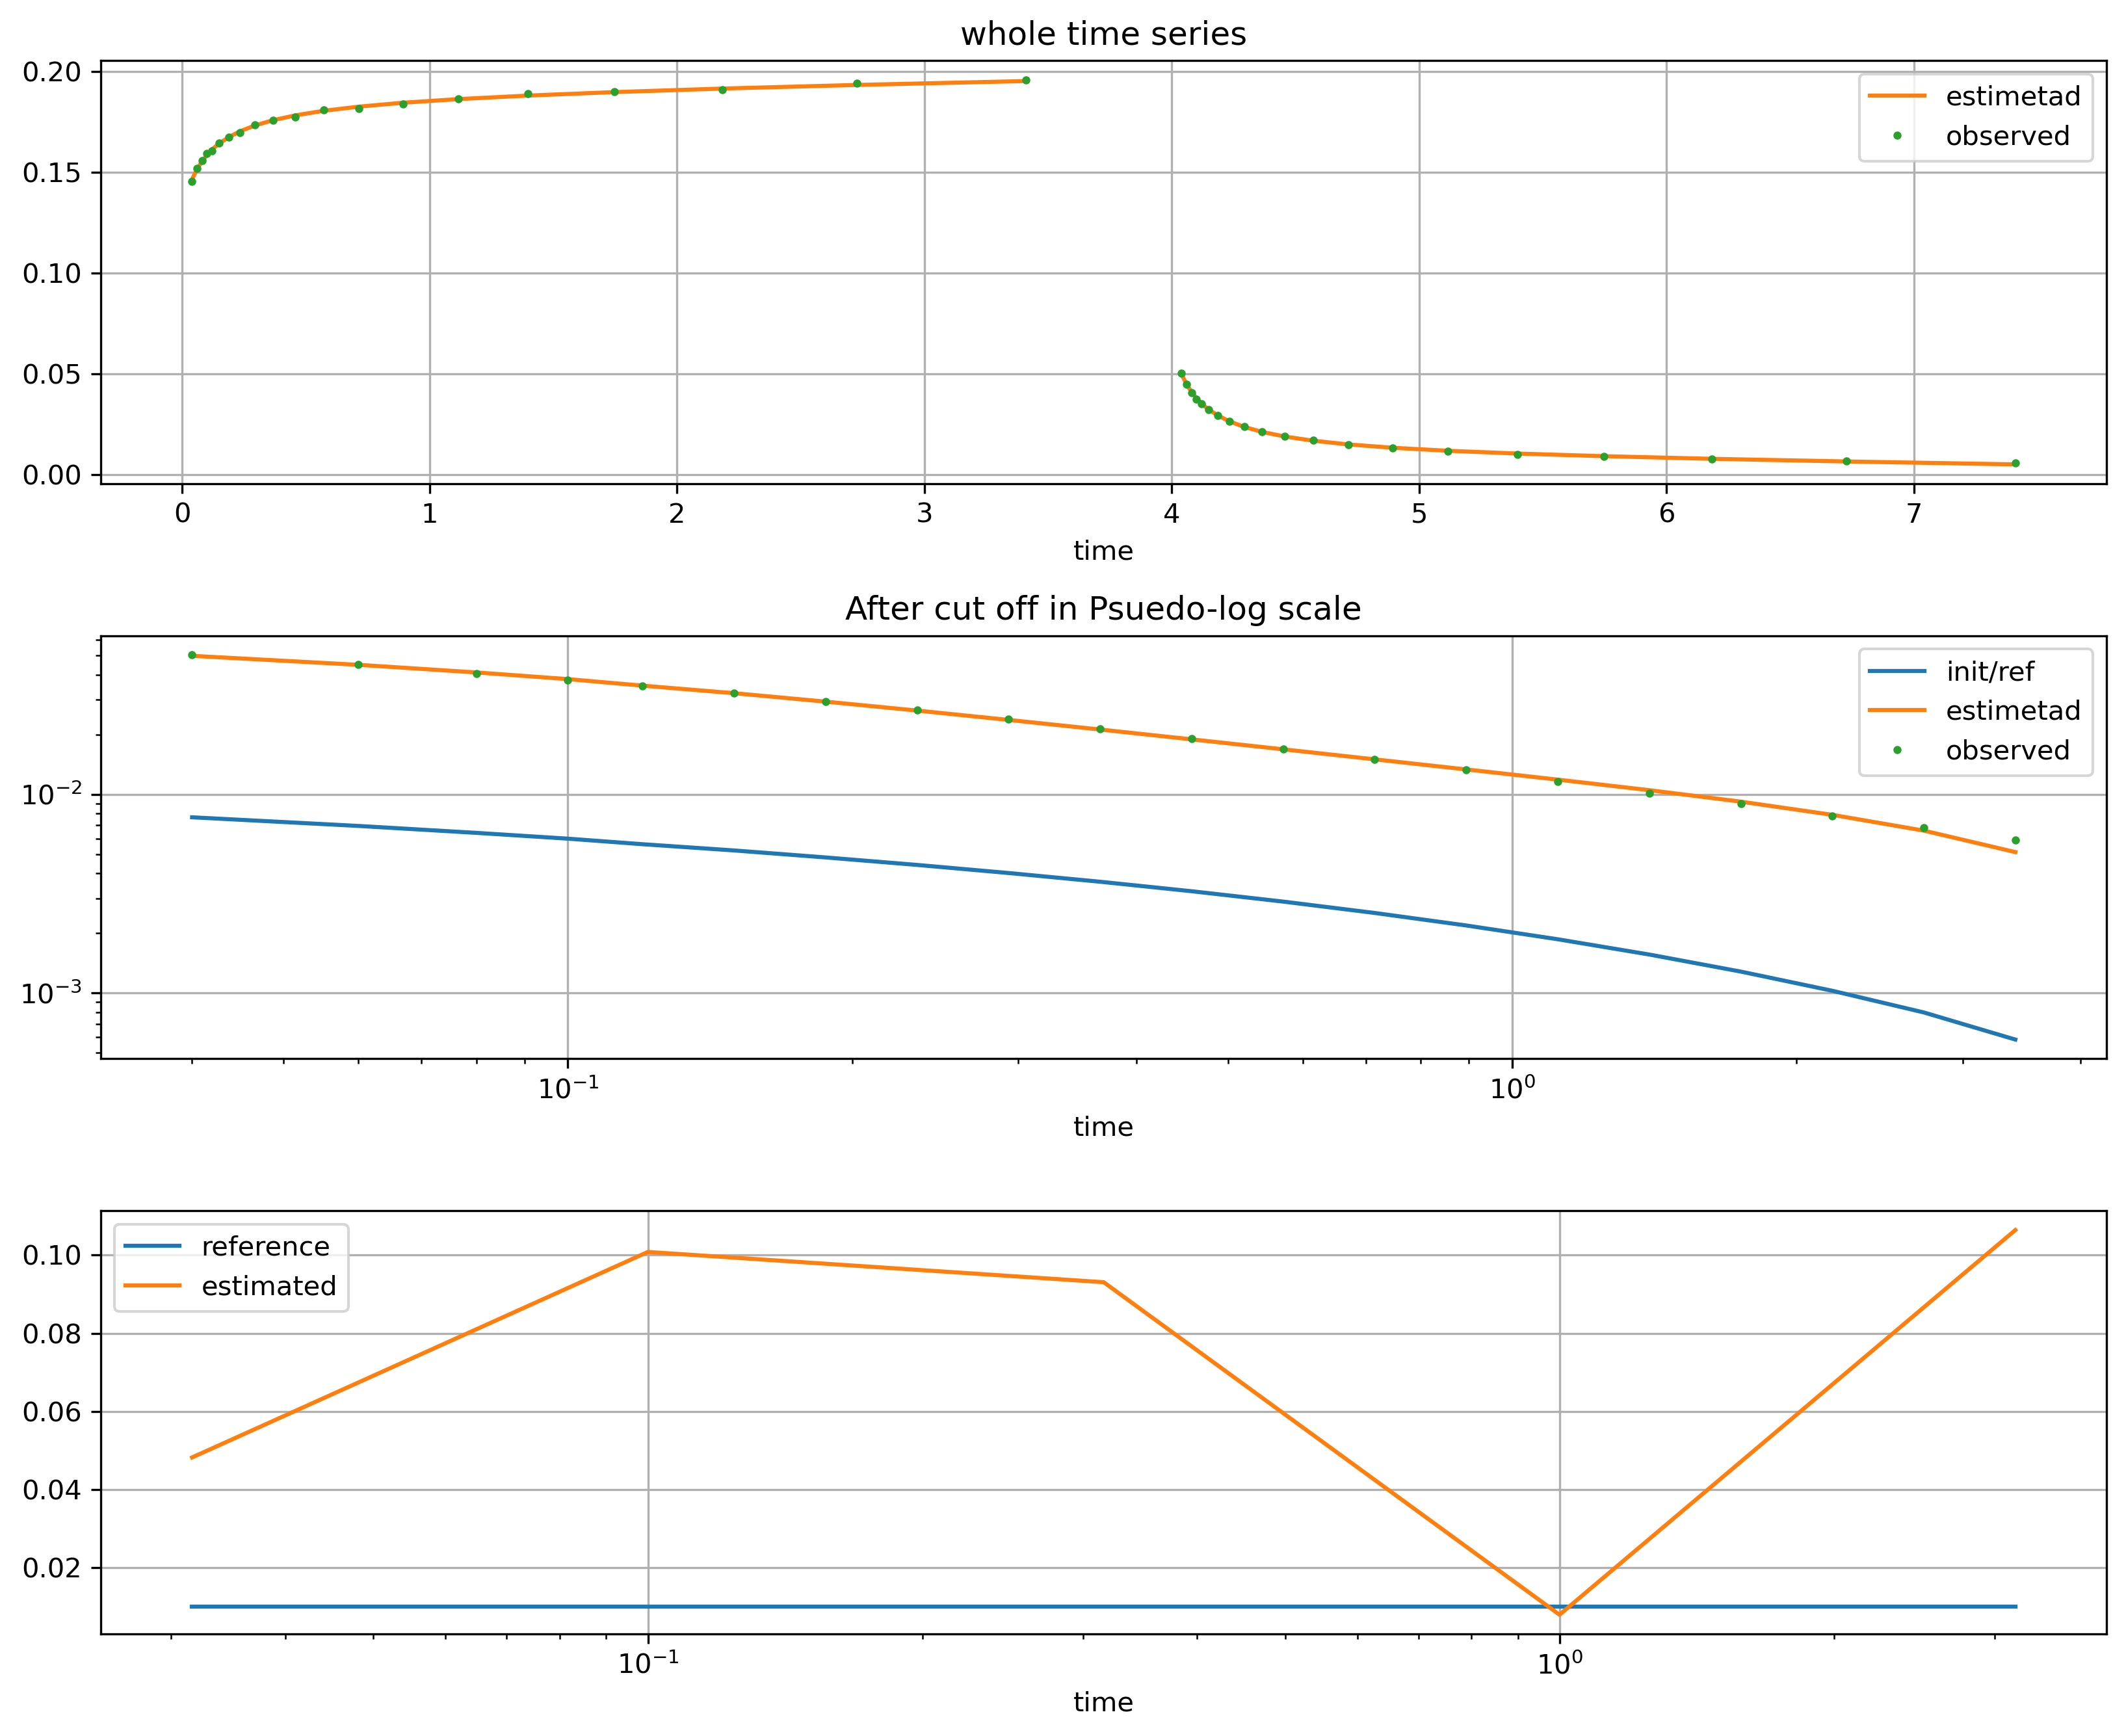

In [150]:
fig, ax = plt.subplots(3, 1, figsize=(11,9),dpi=300)

# ax[0].plot(windows_on,dinit_on, 'C0', label='init/ref')
# ax[0].plot(windows_off,dinit_off, 'C0')
ax[0].plot(windows_on,dest_on, 'C1', label='estimetad')
ax[0].plot(windows_off,dest_off, 'C1')
ax[0].plot(windows_on,dobs_on, 'C2', label='observed',
           linestyle="",markersize=4.0, marker=".",)
ax[0].plot(windows_off,dobs_off, 'C2',
           linestyle="",markersize=4.0, marker=".")

ax[1].loglog(windows_off_0, dinit_off,color='C0', label='init/ref')
ax[1].loglog(windows_off_0, dest_off, color='C1', label='estimetad') 
ax[1].loglog(windows_off_0, dobs_off, 
        color='C2',linestyle="",markersize=4.0, marker=".", label='observed')
ax[2].semilogx(taus, mvec_init[1:1+ntau], color="C0", label="reference")
ax[2].semilogx(taus, mvec_pred[1:1+ntau], color="C1", label="estimated")


# ax[1] = PL_tdip.plpl_plot(x=windows_off_0, y=dest_off, ax=ax[1],
#                 color='C1', label='estimetad') 
# ax[1] = PL_tdip.plpl_plot(x=windows_off_0, y=dobs_off, ax=ax[1],
#         color='C2',linestyle="",markersize=4.0, marker=".", label='observed')

# PL_tdip.pl_axes(ax=ax[1])
# PL_tdip.pl_axes_x(ax=ax[1])

for a in ax:
        a.set_xlabel('time')
        a.grid()
        a.legend()
ax[0].set_title("whole time series")
ax[1].set_title("After cut off in Psuedo-log scale")

plt.tight_layout()

# L1 norm

In [151]:

mpred = opt.GradientDescent(stol=stol,
coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
    mvec_init=parm_init,niter=niter,beta0=beta0,l1reg=True,
    update_Wsen=True,ELS=True, BLS=True)

  1, beta:1.3e+09, step:9.5e-07, gradient:8.0e+05,  f:4.2e+04
  2, beta:1.3e+09, step:9.5e-07, gradient:2.0e+09,  f:5.3e+05
  3, beta:6.6e+08, step:1.9e-06, gradient:1.0e+09,  f:4.2e+04
  4, beta:6.6e+08, step:9.5e-07, gradient:1.0e+09,  f:1.6e+05
  5, beta:3.3e+08, step:1.9e-06, gradient:5.1e+08,  f:4.2e+04
  6, beta:3.3e+08, step:9.5e-07, gradient:5.1e+08,  f:7.2e+04
  7, beta:1.7e+08, step:1.9e-06, gradient:2.5e+08,  f:4.2e+04
  8, beta:1.7e+08, step:9.5e-07, gradient:2.5e+08,  f:4.9e+04
  9, beta:8.3e+07, step:1.9e-06, gradient:1.3e+08,  f:4.2e+04
 10, beta:8.3e+07, step:9.5e-07, gradient:1.3e+08,  f:4.3e+04
 11, beta:4.1e+07, step:1.9e-06, gradient:6.4e+07,  f:4.2e+04
 12, beta:4.1e+07, step:9.5e-07, gradient:6.3e+07,  f:4.2e+04
 13, beta:2.1e+07, step:1.9e-06, gradient:3.3e+07,  f:4.2e+04
 14, beta:2.1e+07, step:9.5e-07, gradient:3.1e+07,  f:4.2e+04
 15, beta:1.0e+07, step:1.9e-06, gradient:1.7e+07,  f:4.2e+04
 16, beta:1.0e+07, step:1.9e-06, gradient:1.5e+07,  f:4.2e+04
 17, bet

In [152]:
np_mvec_prg_L1 = opt.mvec_prg
np_mvec_est_L1 = mpred.detach().numpy()
dest_L1 = opt.dpred(mpred)
mvec_pred_L1 = mpred.detach().numpy()

#taus = np.exp(mvec_pred[1+ntau:])

In [153]:
print(f"initial :{np.exp(np_mvec_init[0]):.2e}, {np_mvec_init[1].sum():.3f}")
print(f"est L1  :{np.exp(np_mvec_est_L1[0]):.2e}, { np_mvec_est_L1[1:].sum():.3f}")
print(f"true    :{np.exp(np_mvec_true[0]):.2e}, {np_mvec_true[1]:.3f}, {np.exp(np_mvec_true[2]):.2e}, {np_mvec_true[3]:.3f}")


initial :2.20e-01, 0.010
est L1  :2.03e-01, 0.357
true    :2.00e-01, 0.500, 1.00e-01, 0.500


In [154]:
dest_on_L1 = dest_L1[ind_on].detach().numpy().flatten()
dest_off_L1 = dest_L1[ind_off].detach().numpy().flatten()

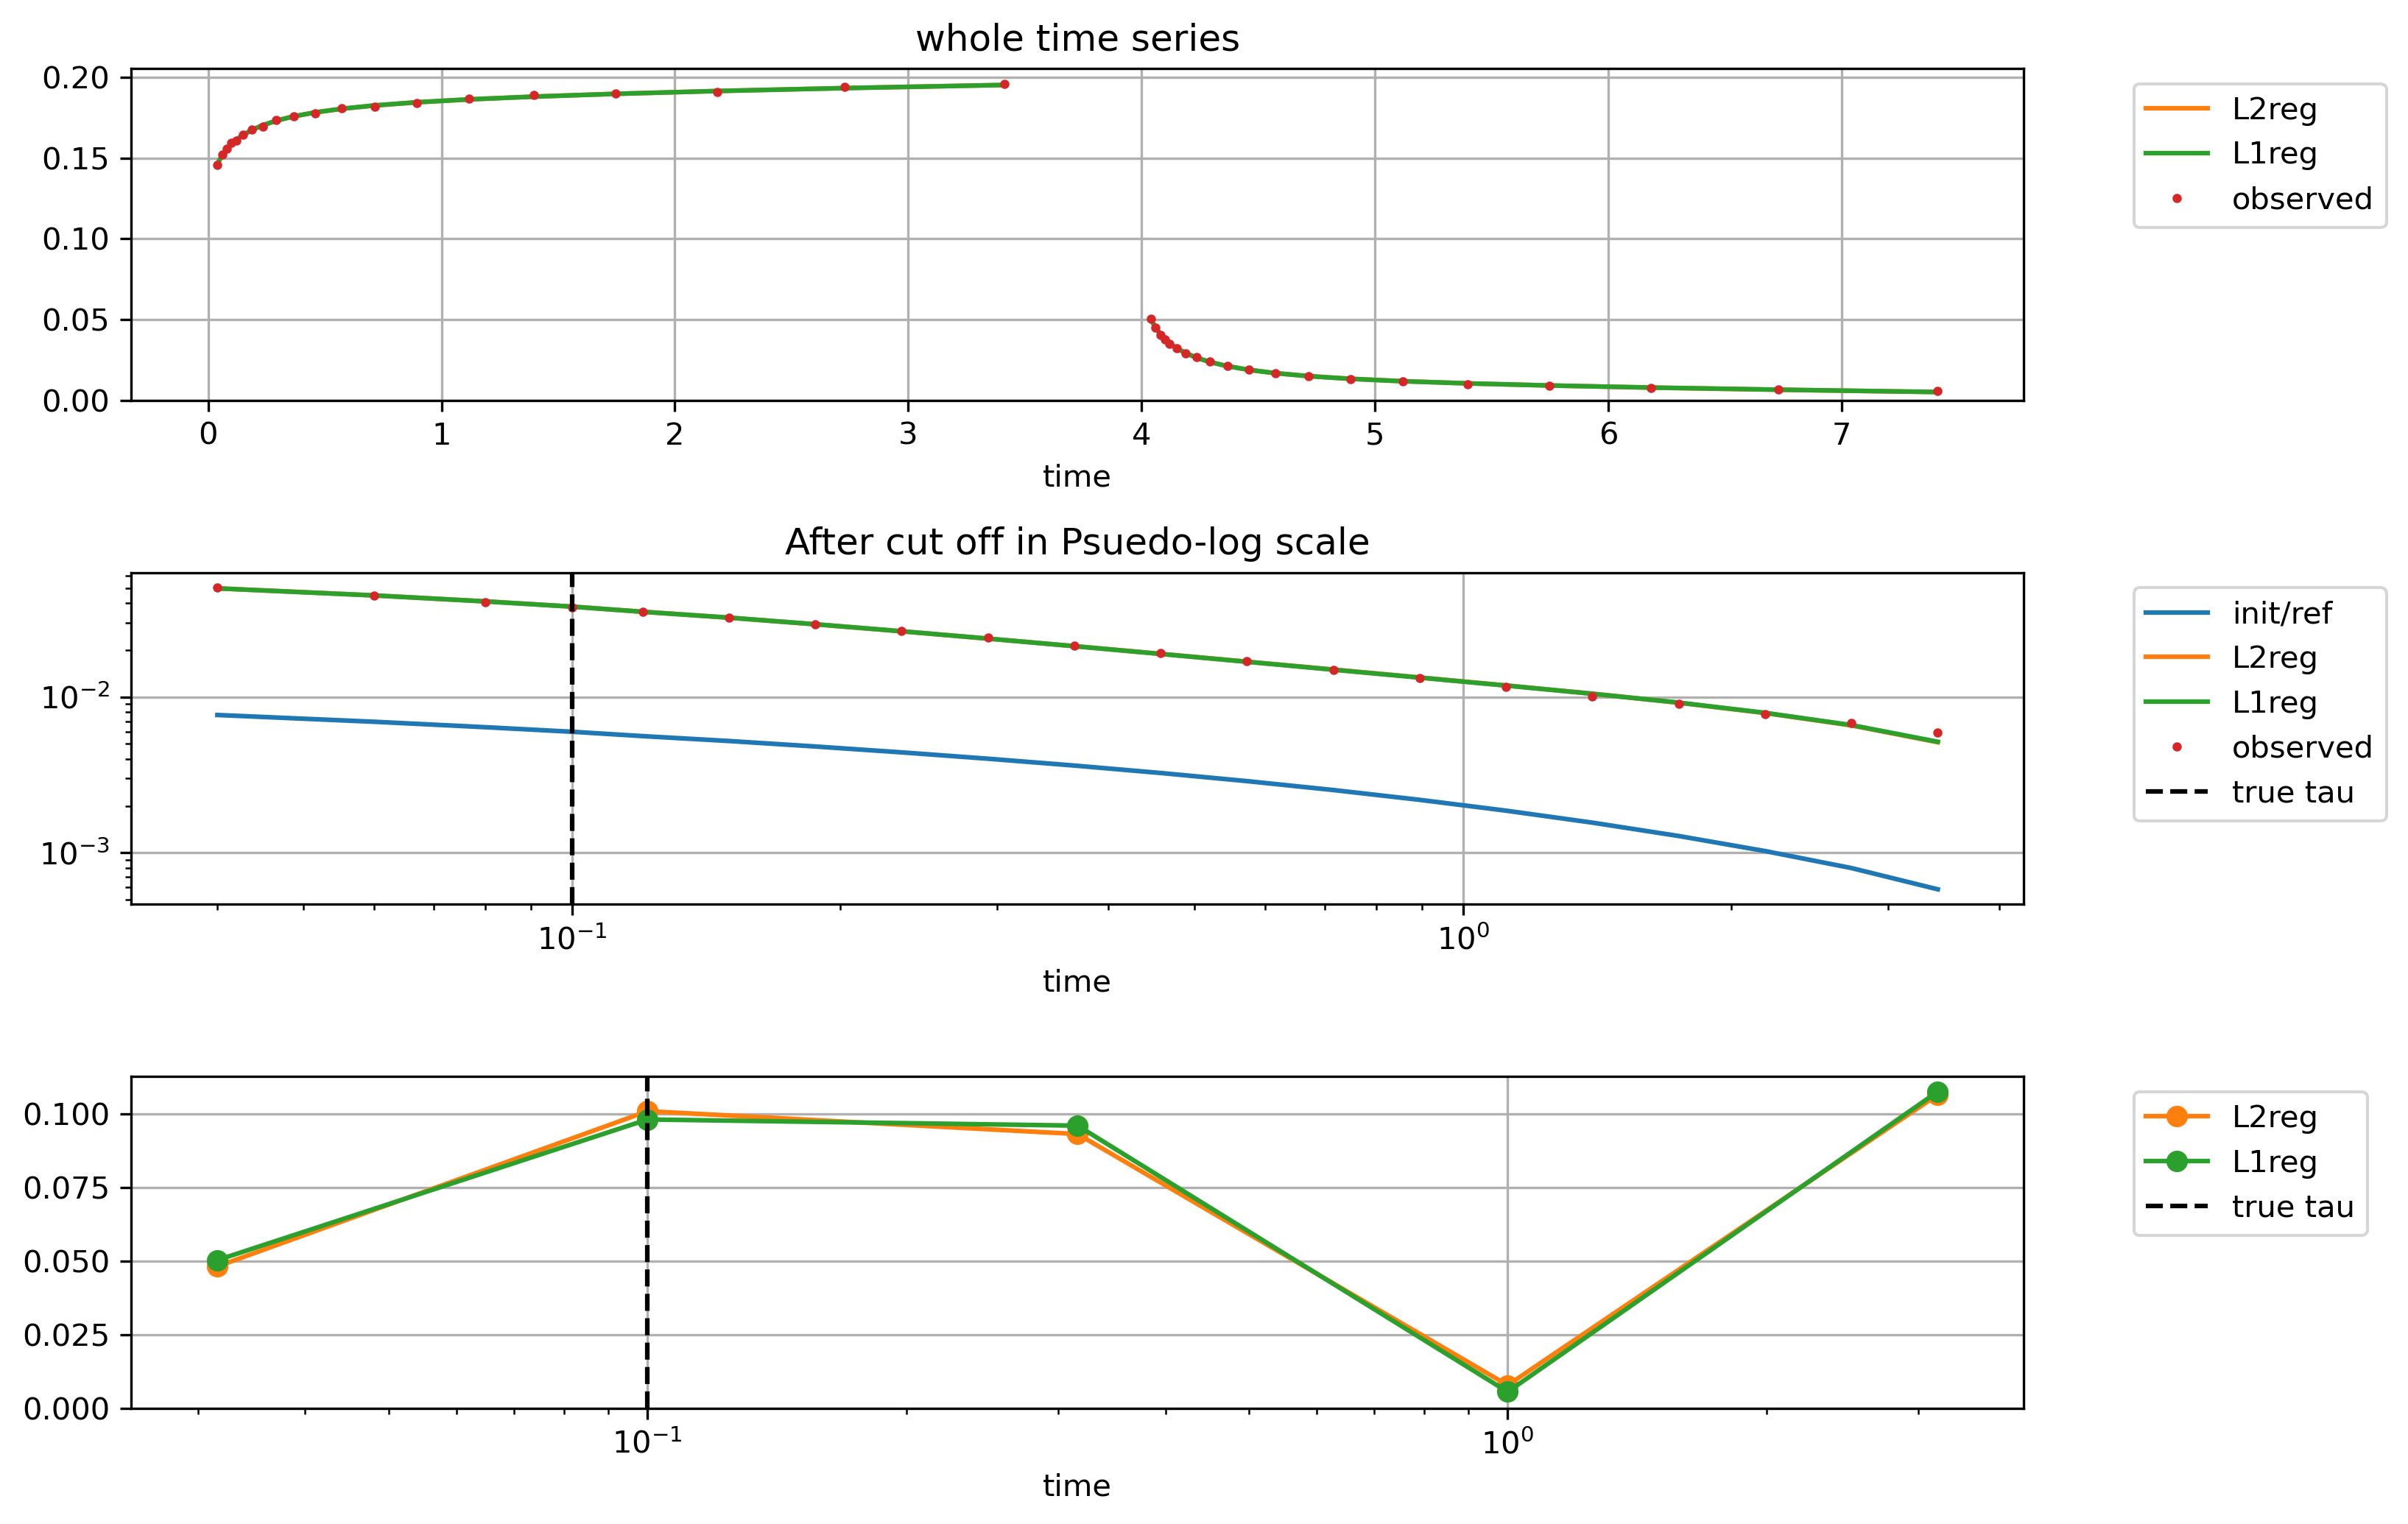

In [155]:
fig, ax = plt.subplots(3, 1, figsize=(11,7),dpi=300)

# ax[0].plot(windows_on,dinit_on, 'C0', label='init/ref')
# ax[0].plot(windows_off,dinit_off, 'C0')
ax[0].plot(windows_on,dest_on, 'C1', label='L2reg')
ax[0].plot(windows_off,dest_off, 'C1')
ax[0].plot(windows_on,dest_on_L1, 'C2', label='L1reg')
ax[0].plot(windows_off,dest_off_L1, 'C2')

ax[0].plot(windows_on,dobs_on, 'C3', label='observed',
           linestyle="",markersize=4.0, marker=".",)
ax[0].plot(windows_off,dobs_off, 'C3',
           linestyle="",markersize=4.0, marker=".")
ax[0].set_ylim(bottom=0)
ax[1].loglog(windows_off_0, dinit_off,color='C0', label='init/ref')
ax[1].loglog(windows_off_0, dest_off, color='C1', label='L2reg') 
ax[1].loglog(windows_off_0, dest_off_L1, color='C2', label='L1reg') 
ax[1].loglog(windows_off_0, dobs_off, 
        color='C3',linestyle="",markersize=4.0, marker=".", label='observed')
ax[1].axvline(x=tau_true, color='k', linestyle="--", label='true tau')

ax[2].semilogx(taus, mvec_pred[1:1+ntau],marker="o", color="C1", label="L2reg")
ax[2].semilogx(taus, mvec_pred_L1[1:1+ntau],marker="o", color="C2", label="L1reg")
ax[2].axvline(x=tau_true, color='k', linestyle="--", label='true tau')
ax[2].set_ylim(bottom=0)
for a in ax:
        a.set_xlabel('time')
        a.grid()
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title("whole time series")
ax[1].set_title("After cut off in Psuedo-log scale")
plt.tight_layout()
plt.savefig("19_Debye_Sum_tdip.jpg", dpi=300)

In [156]:
PL_jac = PsuedoLog(
            logmin=1e-2,
            linScale=0.5,
            logminx=0.1,
            linScalex=1.0)

In [157]:
J= opt.J(mpred )
J_on = J[ind_on].detach().numpy()
J_off = J[ind_off].detach().numpy()

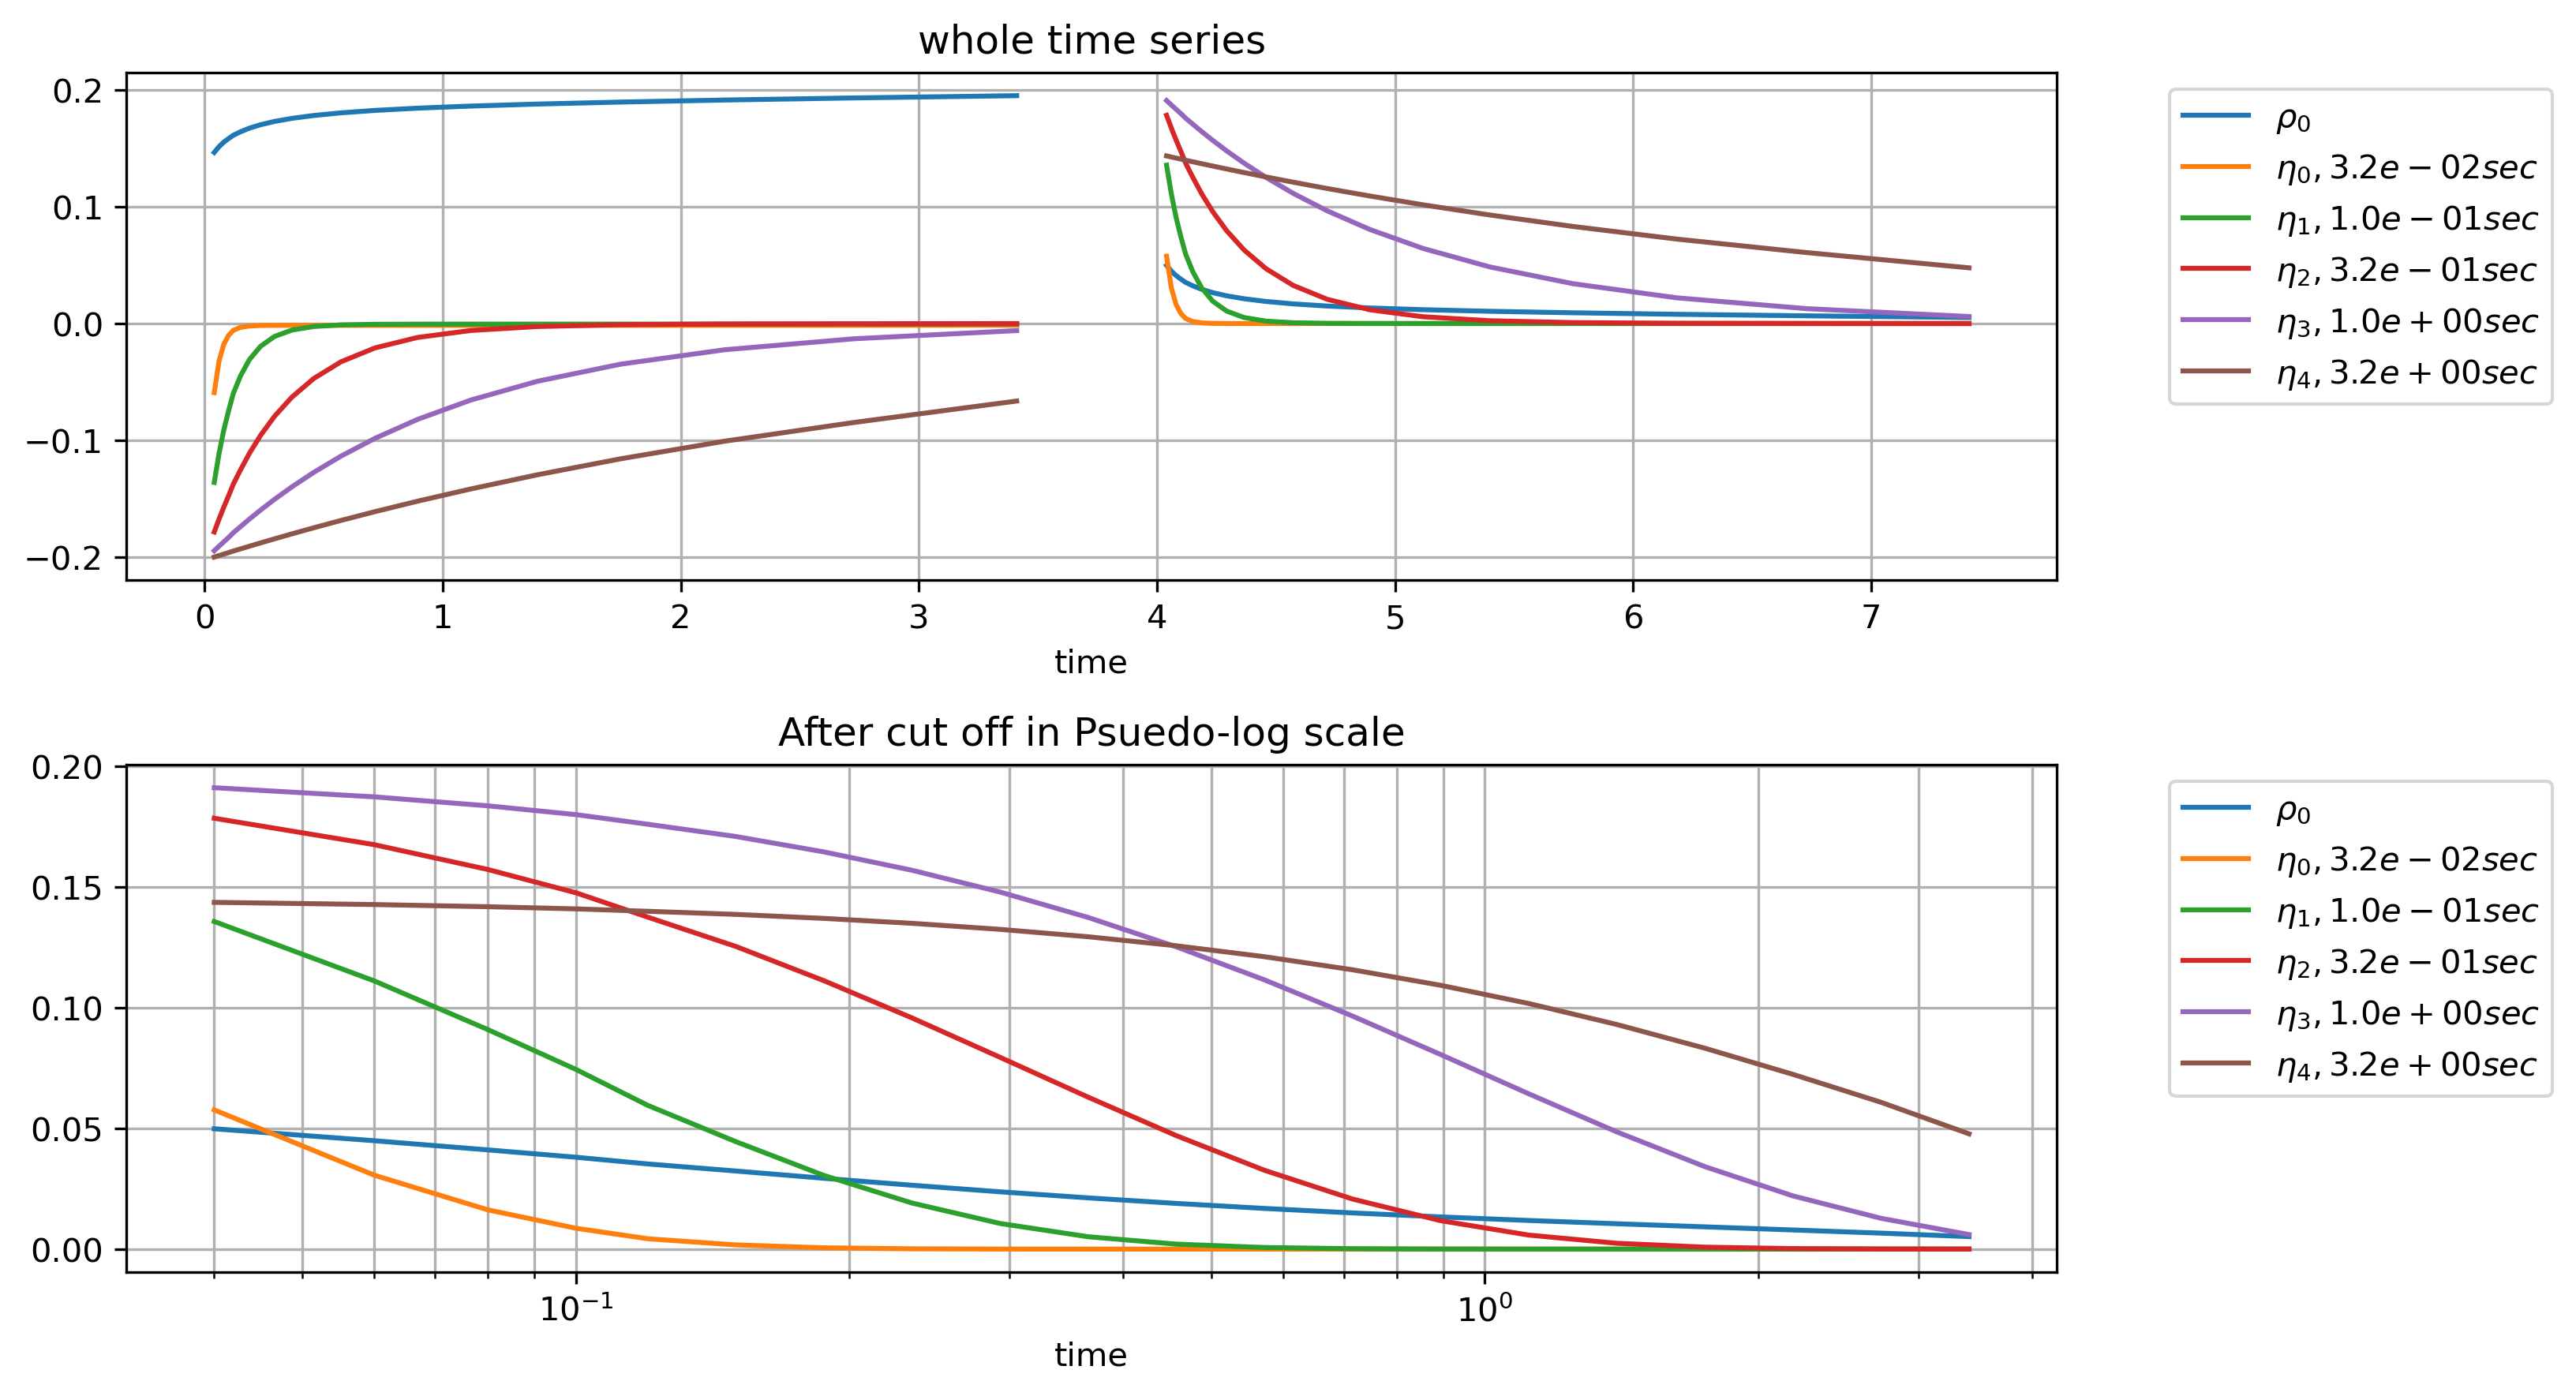

In [158]:
fig, ax = plt.subplots(2, 1, figsize=(11, 6),dpi=300)

ax[0].plot(windows_on,J_on[:,0], 'C0', label=r"$\rho_0$")
ax[0].plot(windows_off,J_off[:,0], 'C0')
for i in range(ntau):
    ax[0].plot(windows_on,J_on[:,i+1], color=f"C{i+1}",
      label=f"$\eta_{i}, {taus[i]:.1e} sec$")
    ax[0].plot(windows_off,J_off[:,i+1], color=f"C{i+1}")

ax[1].semilogx(windows_off_0, J_off[:,0],
             color='C0', label=r"$\rho_0$")
for i in range(ntau):
    ax[1].semilogx(windows_off_0, J_off[:,i+1],
             color=f"C{i+1}", label=f"$\eta_{i}, {taus[i]:.1e} sec$")

# ax[1] = PL_jac.semiply(x=windows_off_0, y=J_off[:,0], ax=ax[1],
#              color='C0', label=r"$\rho_0$")
# for i in range(ntau):
#     ax[1] = PL_jac.semiply(x=windows_off_0, y=J_off[:,i+1], ax=ax[1],
#              color=f"C{i+1}", label=f"$\eta_{i}, {taus[i]:.1e} sec$")
# PL_jac.pl_axes(ax=ax[1])

for a in ax:
        a.set_xlabel('time')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title("whole time series")
ax[1].set_title("After cut off in Psuedo-log scale")
plt.tight_layout()
plt.savefig("19_Debye_Sum_tdip_J.jpg", dpi=300)

# compare singular value of Jacobian

In [170]:
data = np.load("18_SingularValue.npz")
S_pelton_sip = data["Pelton"]
S_LWD_sip = data["LWD"]
taus_sip = data["taus"]


In [172]:
ntau = max(len(taus), len(taus_sip))

In [173]:
J_np = J.detach().numpy()
U, S, V = np.linalg.svd(J_np, full_matrices=False)
S_LWD = S/S.max()

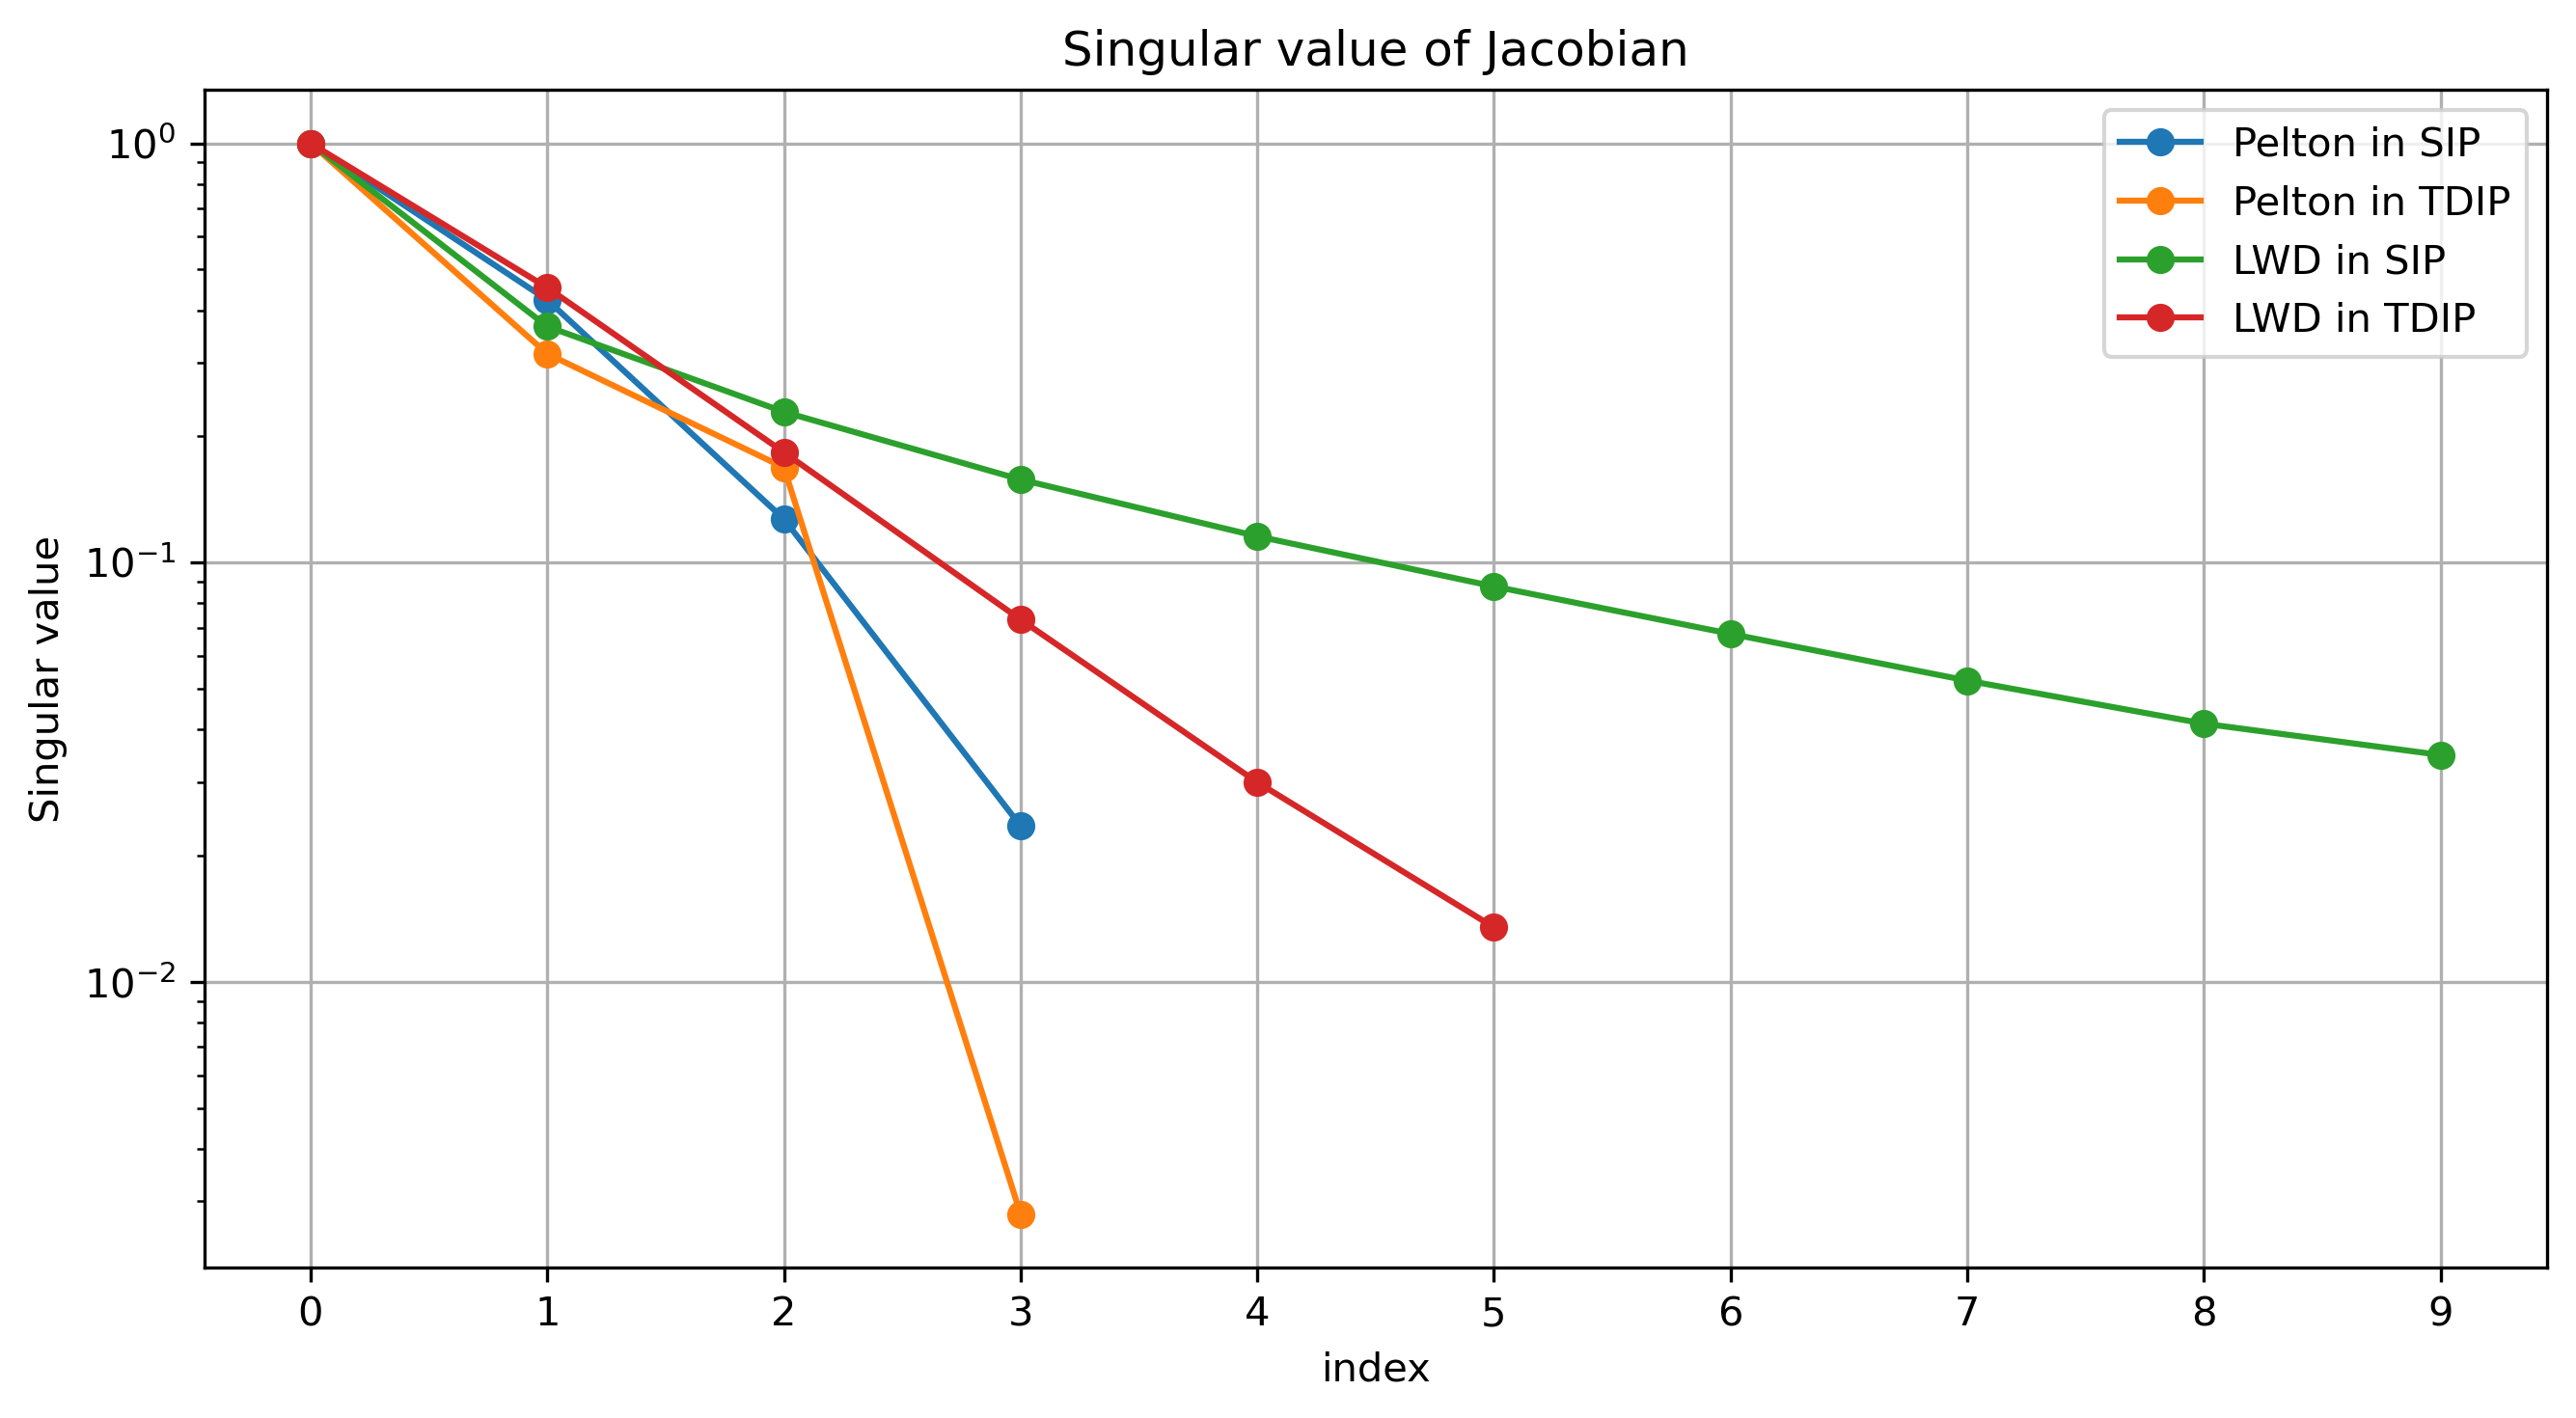

In [174]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=300)
ax.semilogy(S_pelton_sip[0], label='Pelton in SIP', marker="o")
ax.semilogy(S_pelton_norm[0], label='Pelton in TDIP', marker="o")
ax.semilogy(S_LWD_sip, label='LWD in SIP', marker="o")
ax.semilogy(S_LWD, label='LWD in TDIP', marker="o")
ax.set_xticks(range(ntau+1))
ax.grid()
ax.legend()
ax.set_xlabel("index")
ax.set_ylabel("Singular value")
ax.set_title("Singular value of Jacobian")
plt.tight_layout()
plt.savefig("19_Singular_Copmparison.jpg", dpi=300)

In [62]:
# taus_torch = sim.ip_model.taus
# times_view = sim.times.view(-1,1)   
# times_view= times_view[:4]
# print(times_view)
# etas_torch =mpred[1:].view(1,-1)
# taus_view = taus_torch.view(1,-1)
# print(taus_view)
# print(etas_torch)
# print(torch.exp(-times_view/taus_view))
# print(etas_torch.sum(dim=1))